# Pruebas de ajuste a 3 catenarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# 3D Libs
import open3d as o3d
import laspy
print(laspy.__version__)

# Geospatial libs
import rasterio
import alphashape as ash
import geopandas as gpd
import shapely as sh    

from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.features import shapes
from shapely.geometry import Polygon

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import SpectralClustering

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


ModuleNotFoundError: No module named 'laspy'

In [ ]:
%pip inS

In [149]:
def get_coord(points):
    
    x_vals = [punto[0] for punto in points]
    y_vals = [punto[1] for punto in points]
    z_vals = [punto[2] for punto in points]
    
    return np.stack(x_vals), np.stack(y_vals), np.stack(z_vals)

def get_coord2(extremos_apoyos):
    
    x_vals = [extremos_apoyos[0]["COORDENADA_X"], extremos_apoyos[0]["COORDENADA_X"], extremos_apoyos[1]["COORDENADA_X"], extremos_apoyos[1]["COORDENADA_X"]]
    y_vals = [extremos_apoyos[0]["COORDEANDA_Y"], extremos_apoyos[0]["COORDEANDA_Y"], extremos_apoyos[1]["COORDEANDA_Y"], extremos_apoyos[1]["COORDEANDA_Y"]]
    z_vals = extremos_apoyos[0]["COORDENADAS_Z"] + extremos_apoyos[1]["COORDENADAS_Z"]

    return np.stack(x_vals), np.stack(y_vals), np.stack(z_vals)

def unravel_data_element(element):
    
    for key in element.keys():
    
        if type(element[key]) in [list, dict]:
            
            print(f"\n{key}: ")
            
            if type(element[key]) == list:
            
                element2 = element[key][0]
                print(f"- Length of list: {len(element[key])}")
                
            else:
                
                element2 = element[key]
            
            for key2 in element2.keys():
                
                print(f"    {key2}: {element2[key2]}")
                
                if type(element2[key2]) == list:
                    print(f"    - Length of list: {len(element2[key2])}")
        
        else:
            print(f"\n{key}: {element[key]}")

Obtenemos los datos

In [150]:
import json

path = "../data/"

with open(path+'vanos.json', 'r') as archivo:
    data1 = json.load(archivo)

with open(path+'datos1.json', 'r') as archivo:
    data2 = json.load(archivo)

with open(path+'datos2.json', 'r') as archivo:
    data3 = json.load(archivo)

Función de rotación

In [151]:
def rotate_points(points, extremos_values):
    
    points = np.array(points).T

    extremo1 = np.array(extremos_values).T[0]  # Extremo superior del primer poste
    extremo2 = np.array(extremos_values).T[2]  # Extremo inferior del primer poste
    
    # Calcular la distancia en el plano XY y la dirección de la diagonal
    distancia_xy = np.linalg.norm(extremo2[:2] - extremo1[:2])
    direccion_diagonal = (extremo2[:2] - extremo1[:2]) / distancia_xy # Normalizada para la distancia
    
    # Calcular el ángulo de rotación necesario para alinear la diagonal con el eje Y
    angulo = np.arctan2(direccion_diagonal[1], direccion_diagonal[0])
    
    # Ajustar el ángulo para la rotación correcta
    angulo += np.pi / 2
    c, s = np.cos(angulo), np.sin(angulo)
    
    # Crear la matriz de rotación para alinear la diagonal con el eje Y
    matriz_rotacion = np.array([[c, s, 0],
                                [-s, c, 0],
                                [0, 0, 1]])
    
    rotated_points = matriz_rotacion.dot(points.T)
    # print(rotated.shape)
    
    return matriz_rotacion, np.array(rotated_points)

Función que obtiene 3 ajustes a catenarias y 3 polilíneas

In [152]:
def ajuste(data, vano):

    puntos_conductores = data[vano]['LIDAR']['CONDUCTORES']
    puntos_vertices = data[vano]['CONDUCTORES'][0]['VERTICES']
    puntos_vertices2 = data[vano]['CONDUCTORES'][1]['VERTICES']
    puntos_vertices3 = data[vano]['CONDUCTORES'][2]['VERTICES']
    puntos_extremos = data[vano]['APOYOS']

    x_vals_conductores, y_vals_conductores, z_vals_conductores = get_coord(puntos_conductores)
    x_vals_extremos, y_vals_extremos, z_vals_extremos = get_coord2(puntos_extremos)
    x_vert1, y_vert1, z_vert1 = get_coord(puntos_vertices)
    x_vert2, y_vert2, z_vert2 = get_coord(puntos_vertices2)
    x_vert3, y_vert3, z_vert3 = get_coord(puntos_vertices3)

    cond_values = [x_vals_conductores, y_vals_conductores, z_vals_conductores]
    extremos_values = [x_vals_extremos, y_vals_extremos, z_vals_extremos]
    vert_values1 = [x_vert1, y_vert1, z_vert1]
    vert_values2 = [x_vert2, y_vert2, z_vert2]
    vert_values3 = [x_vert3, y_vert3, z_vert3]

    # Matriz de rotación
    mat, rotated_conds = rotate_points(cond_values, extremos_values)
    extremos_values = mat.dot(extremos_values)
    rotated_vertices1 = mat.dot(vert_values1)
    rotated_vertices2 = mat.dot(vert_values2)
    rotated_vertices3 = mat.dot(vert_values3)

    X_extremos = extremos_values[0]
    Y_extremos = extremos_values[1]
    Z_extremos = extremos_values[2]

    X_cond = rotated_conds[0]
    Y_cond = rotated_conds[1]
    Z_cond = rotated_conds[2]

    # Filtramos los puntos de los conductores que están entre los extremos
    x = []
    y = []
    z = []

    for i in range(len(X_cond)):
        if Y_cond[i] > np.min(Y_extremos) and Y_cond[i] < np.max(Y_extremos):
            x.append(X_cond[i])
            y.append(Y_cond[i])
            z.append(Z_cond[i])

    x_cond = np.array(x)
    y_cond = np.array(y)
    z_cond = np.array(z)

    # Clustering
    [X, y] = [x_cond.reshape(-1, 1), y_cond.reshape(-1, 1)]

    model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=0)

    y_spectral = model.fit_predict(X)

    # Separamos los 3 cables
    x1, x2, x3 = [], [], []
    y1, y2, y3 = [], [], []
    z1, z2, z3 = [], [], []

    for i in range(0, len(y_spectral)):
        if y_spectral[i] == 0:
            x1.append(X[i])
            y1.append(y[i])
            z1.append(z[i])
        if y_spectral[i] == 1:
            x2.append(X[i])
            y2.append(y[i])
            z2.append(z[i])
        if y_spectral[i] == 2:
            x3.append(X[i])
            y3.append(y[i])
            z3.append(z[i])

    x1, y1, z1 = np.array(x1), np.array(y1), np.array(z1)
    x2, y2, z2 = np.array(x2), np.array(y2), np.array(z2)
    x3, y3, z3 = np.array(x3), np.array(y3), np.array(z3)

    # Ajuste de la catenaria
    data_2d_cond1 = np.column_stack((y1, z1))
    data_2d_cond2 = np.column_stack((y2, z2))
    data_2d_cond3 = np.column_stack((y3, z3))

    pca = PCA(n_components=2)
    data_2d_pca_cond1 = pca.fit_transform(data_2d_cond1)
    data_2d_pca_cond2 = pca.fit_transform(data_2d_cond2)
    data_2d_pca_cond3 = pca.fit_transform(data_2d_cond3)

    y_min_cond1, y_max_cond1 = data_2d_pca_cond1[:, 1].min(), data_2d_pca_cond1[:,1].max()
    y_min_cond2, y_max_cond2 = data_2d_pca_cond2[:, 1].min(), data_2d_pca_cond2[:,1].max()
    y_min_cond3, y_max_cond3 = data_2d_pca_cond3[:, 1].min(), data_2d_pca_cond3[:,1].max()

    f_ind1 = (data_2d_pca_cond1[:,1] > y_min_cond1) & (data_2d_pca_cond1[:,1] < y_max_cond1)
    f_ind2 = (data_2d_pca_cond2[:,1] > y_min_cond2) & (data_2d_pca_cond2[:,1] < y_max_cond2)
    f_ind3 = (data_2d_pca_cond3[:,1] > y_min_cond3) & (data_2d_pca_cond3[:,1] < y_max_cond3)
    x_filt_cond1, y_filt_cond1, z_filt_cond1 = x1[f_ind1], y1[f_ind1], z1[f_ind1]
    x_filt_cond2, y_filt_cond2, z_filt_cond2 = x2[f_ind2], y2[f_ind2], z2[f_ind2]
    x_filt_cond3, y_filt_cond3, z_filt_cond3 = x3[f_ind3], y3[f_ind3], z3[f_ind3]

    # Función de la catenaria
    from sklearn.preprocessing import StandardScaler
    from scipy.optimize import curve_fit
    def catenaria(x, a, h, k):
        return a*np.cosh((x-h)/a)+k

    y_vals1 = y_filt_cond1.reshape(-1, 1)
    z_vals1 = z_filt_cond1.reshape(-1, 1)
    y_vals2 = y_filt_cond2.reshape(-1, 1)
    z_vals2 = z_filt_cond2.reshape(-1, 1)
    y_vals3 = y_filt_cond3.reshape(-1, 1)
    z_vals3 = z_filt_cond3.reshape(-1, 1)


    scaler_y1 = StandardScaler()
    scaler_z1 = StandardScaler()
    scaler_y2 = StandardScaler()
    scaler_z2 = StandardScaler()
    scaler_y3 = StandardScaler()
    scaler_z3 = StandardScaler()

    y_vals_scaled1 = scaler_y1.fit_transform(y_vals1).flatten()
    z_vals_scaled1 = scaler_z1.fit_transform(z_vals1).flatten()
    y_vals_scaled2 = scaler_y2.fit_transform(y_vals2).flatten()
    z_vals_scaled2 = scaler_z2.fit_transform(z_vals2).flatten()
    y_vals_scaled3 = scaler_y3.fit_transform(y_vals3).flatten()
    z_vals_scaled3 = scaler_z3.fit_transform(z_vals3).flatten()

    p0 = [1, 0, 0]

    parametros1, _ = curve_fit(catenaria, y_vals_scaled1.flatten(), z_vals_scaled1)
    parametros2, _ = curve_fit(catenaria, y_vals_scaled2.flatten(), z_vals_scaled2)
    parametros3, _ = curve_fit(catenaria, y_vals_scaled3.flatten(), z_vals_scaled3)

    # Ajuste de los puntos de los datos a una catenaria
    fitted_z_vals_scaled1 = catenaria(y_vals_scaled1.flatten(), *parametros1)
    fitted_z_vals1 = scaler_z1.inverse_transform(fitted_z_vals_scaled1.reshape(-1, 1)).flatten()
    fitted_z_vals_scaled2 = catenaria(y_vals_scaled2.flatten(), *parametros2)
    fitted_z_vals2 = scaler_z2.inverse_transform(fitted_z_vals_scaled2.reshape(-1, 1)).flatten()
    fitted_z_vals_scaled3 = catenaria(y_vals_scaled3.flatten(), *parametros3)
    fitted_z_vals3 = scaler_z3.inverse_transform(fitted_z_vals_scaled3.reshape(-1, 1)).flatten()

    plt.figure(figsize=(10, 6))
    # Pintamos los puntos de cada cable
    plt.scatter(y1, z1, color='coral', s=30)
    plt.scatter(y2, z2, color='lightblue', s=30)
    plt.scatter(y3, z3, color='lightgreen', s=30)

    # Interpolación de la polilínea
    minimo1 = np.min(scaler_y1.inverse_transform(y_vals_scaled1.reshape(-1, 1)).flatten())
    maximo1 = np.max(scaler_y1.inverse_transform(y_vals_scaled1.reshape(-1, 1)).flatten())
    x_pol1 = np.linspace(minimo1, maximo1, 1000)

    minimo2 = np.min(scaler_y2.inverse_transform(y_vals_scaled2.reshape(-1, 1)).flatten())
    maximo2 = np.max(scaler_y2.inverse_transform(y_vals_scaled2.reshape(-1, 1)).flatten())
    x_pol2 = np.linspace(minimo2, maximo2, 1000)

    minimo3 = np.min(scaler_y3.inverse_transform(y_vals_scaled3.reshape(-1, 1)).flatten())
    maximo3 = np.max(scaler_y3.inverse_transform(y_vals_scaled3.reshape(-1, 1)).flatten())
    x_pol3 = np.linspace(minimo3, maximo3, 1000)

    scaler_x1 = StandardScaler()
    scaler_x2 = StandardScaler()
    scaler_x3 = StandardScaler()

    x_scaled1 = scaler_x1.fit_transform(x_pol1.reshape(-1, 1)).flatten()
    x_scaled2 = scaler_x2.fit_transform(x_pol2.reshape(-1, 1)).flatten()
    x_scaled3 = scaler_x3.fit_transform(x_pol3.reshape(-1, 1)).flatten()

    fitted_y_scaled1 = catenaria(x_scaled1.flatten(), *parametros1)
    fitted_y1 = scaler_z1.inverse_transform(fitted_y_scaled1.reshape(-1, 1)).flatten()
    fitted_y_scaled2 = catenaria(x_scaled2.flatten(), *parametros2)
    fitted_y2 = scaler_z2.inverse_transform(fitted_y_scaled2.reshape(-1, 1)).flatten()
    fitted_y_scaled3 = catenaria(x_scaled3.flatten(), *parametros3)
    fitted_y3 = scaler_z3.inverse_transform(fitted_y_scaled3.reshape(-1, 1)).flatten()

    y_pol1 = np.interp(x_pol1, scaler_y1.inverse_transform(y_vals_scaled1.reshape(-1, 1)).flatten(), fitted_z_vals1, period=len(fitted_z_vals3))
    y_pol2 = np.interp(x_pol2, scaler_y2.inverse_transform(y_vals_scaled2.reshape(-1, 1)).flatten(), fitted_z_vals2, period=len(fitted_z_vals3))
    y_pol3 = np.interp(x_pol3, scaler_y3.inverse_transform(y_vals_scaled3.reshape(-1, 1)).flatten(), fitted_z_vals3, period=len(fitted_z_vals3))

    # Pintamos las polilíneas que hemos generado
    plt.plot(x_pol1, y_pol1, color='red', label='P1')
    plt.plot(x_pol2, y_pol2, color='blue', label='P2')
    plt.plot(x_pol3, y_pol3, color='green', label='P3')

    # Pintamos las polilíneas que nos dan con los datos
    plt.scatter(rotated_vertices1[1], rotated_vertices1[2], color='red', label='Polilínea 1', s=30)
    plt.scatter(rotated_vertices2[1], rotated_vertices2[2], color='blue', label='Polilínea 2', s=30)
    plt.scatter(rotated_vertices3[1], rotated_vertices3[2], color='green', label='Polilínea 3', s=30)

    plt.legend()
    plt.title(vano)

Probamos con los casos que queremos mejorar (con huecos)

/home/paula-ubuntu/.asdf/installs/python/3.10.13/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


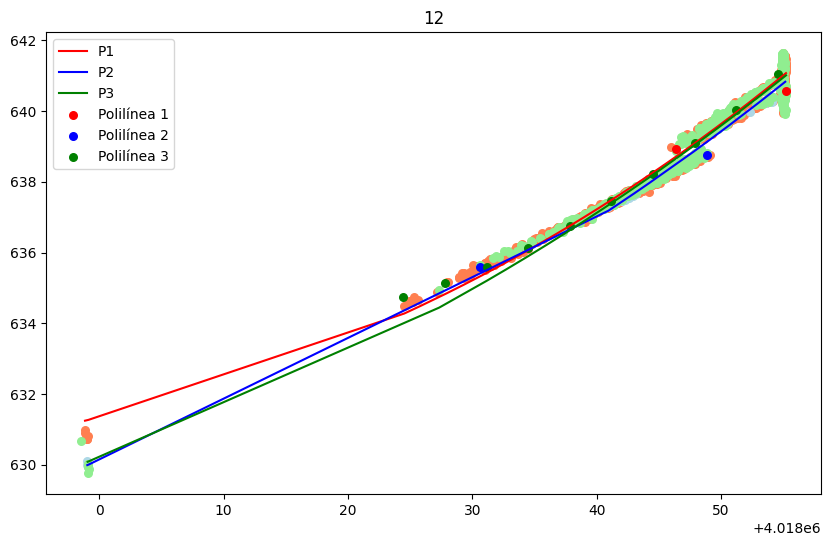

In [153]:
ajuste(data1, 12)

/home/paula-ubuntu/.asdf/installs/python/3.10.13/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


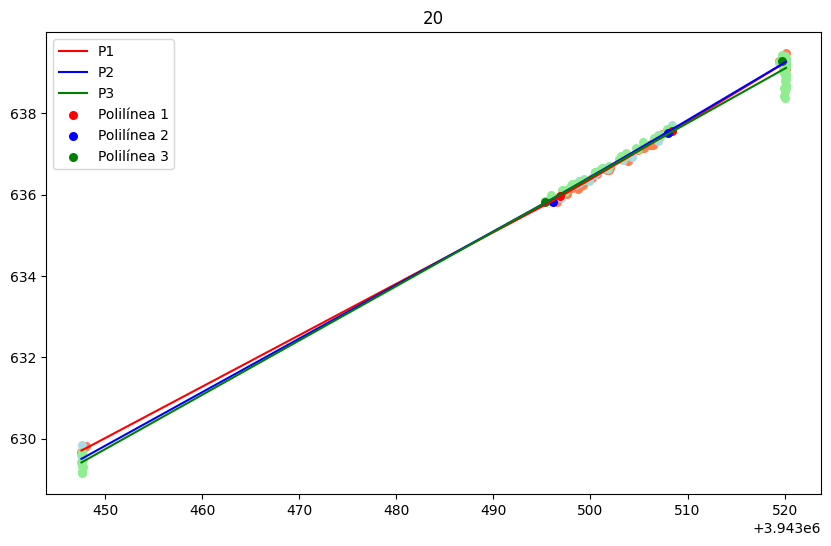

In [154]:
ajuste(data1, 20)

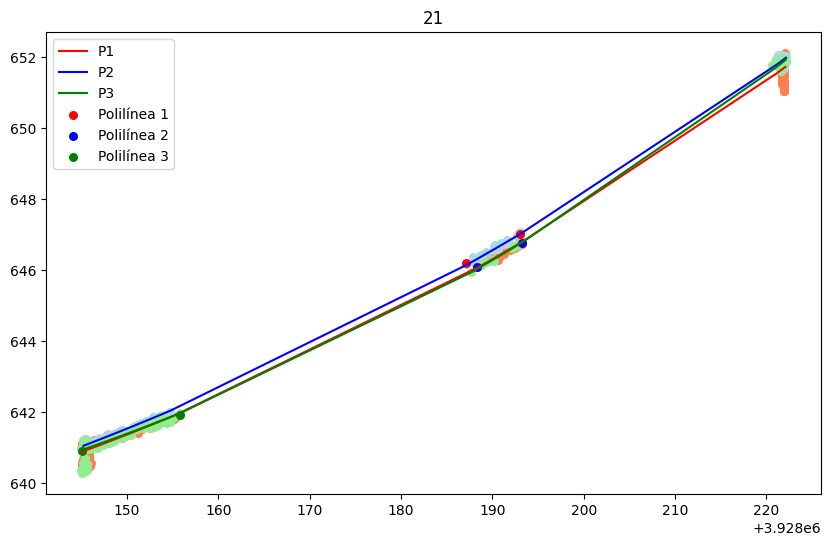

In [155]:
ajuste(data1, 21)

/home/paula-ubuntu/.asdf/installs/python/3.10.13/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


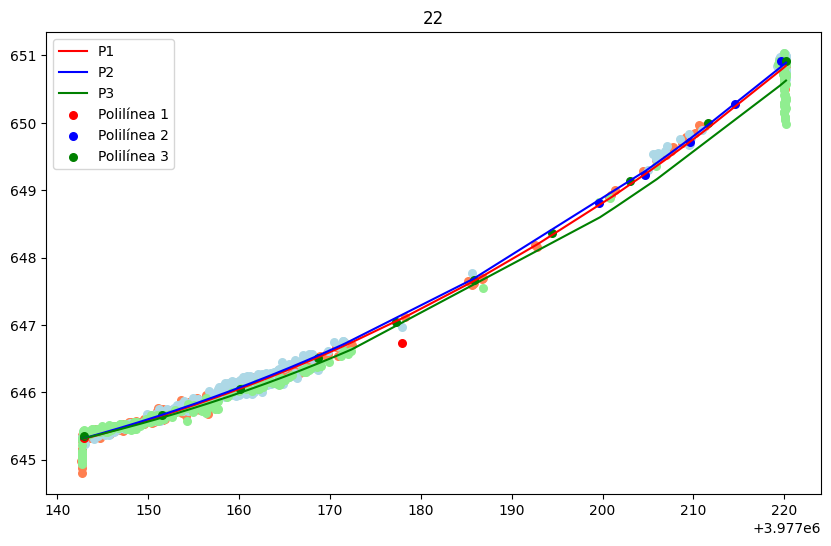

In [156]:
ajuste(data1, 22)

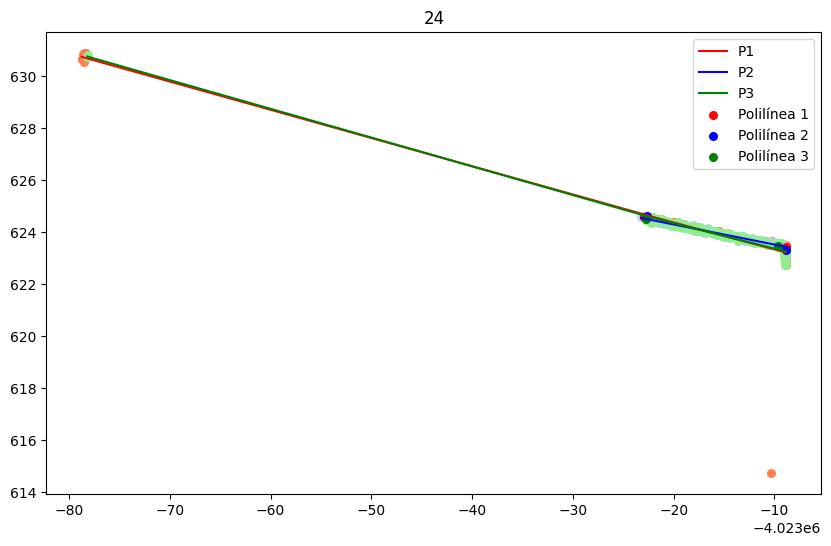

In [157]:
ajuste(data1, 24)

/home/paula-ubuntu/.asdf/installs/python/3.10.13/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


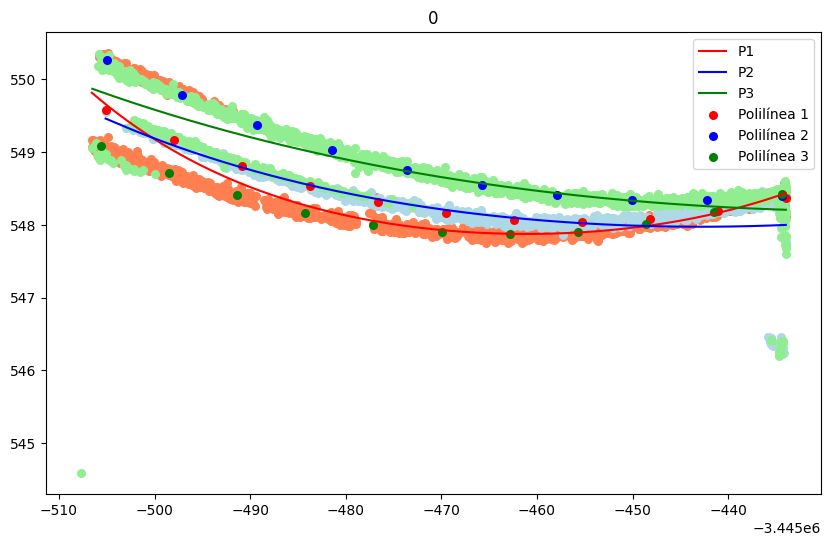

In [158]:
ajuste(data2, 0)

/home/paula-ubuntu/.asdf/installs/python/3.10.13/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


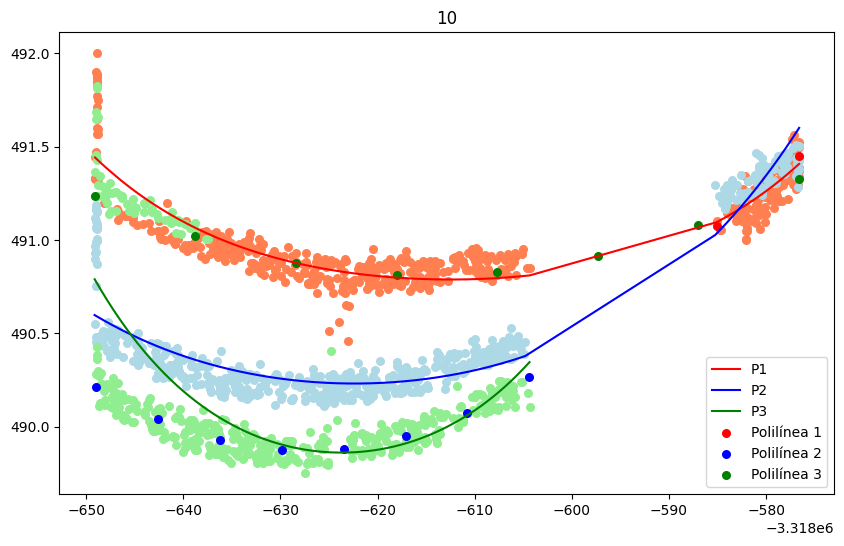

In [159]:
ajuste(data2, 10)

/home/paula-ubuntu/.asdf/installs/python/3.10.13/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


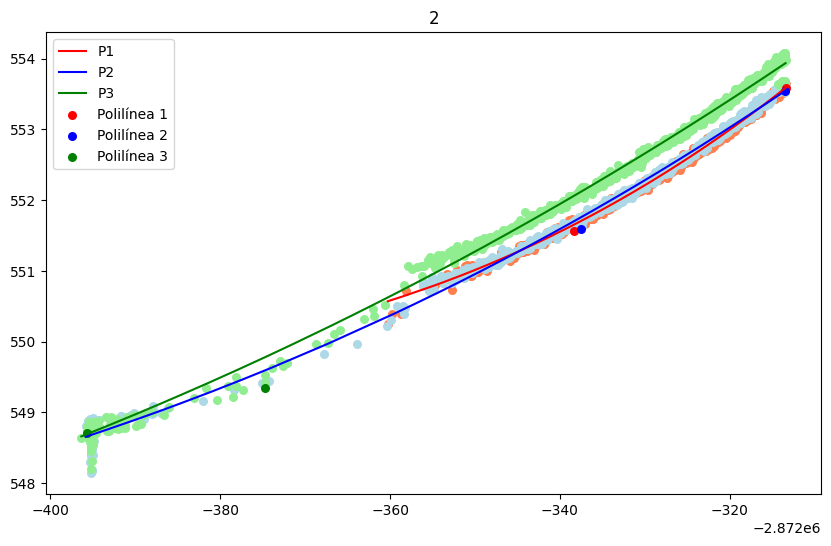

In [160]:
ajuste(data3, 2)

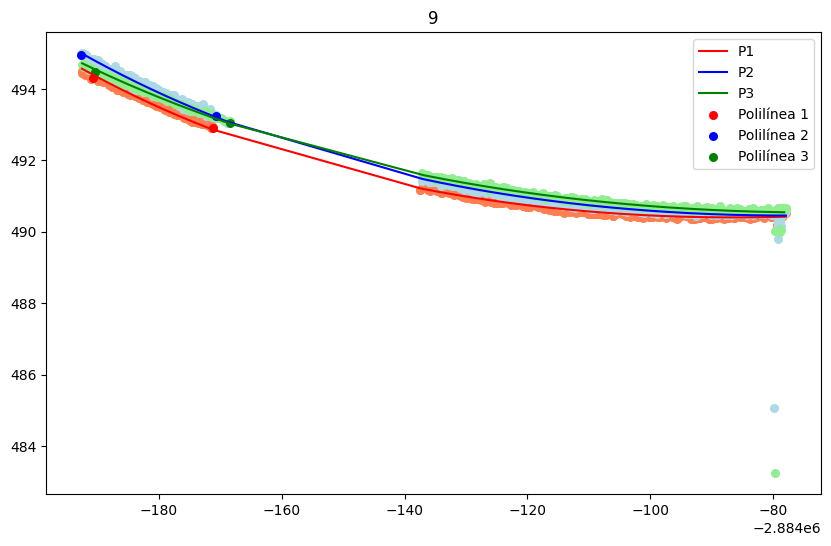

In [161]:
ajuste(data3, 9)

/home/paula-ubuntu/.asdf/installs/python/3.10.13/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


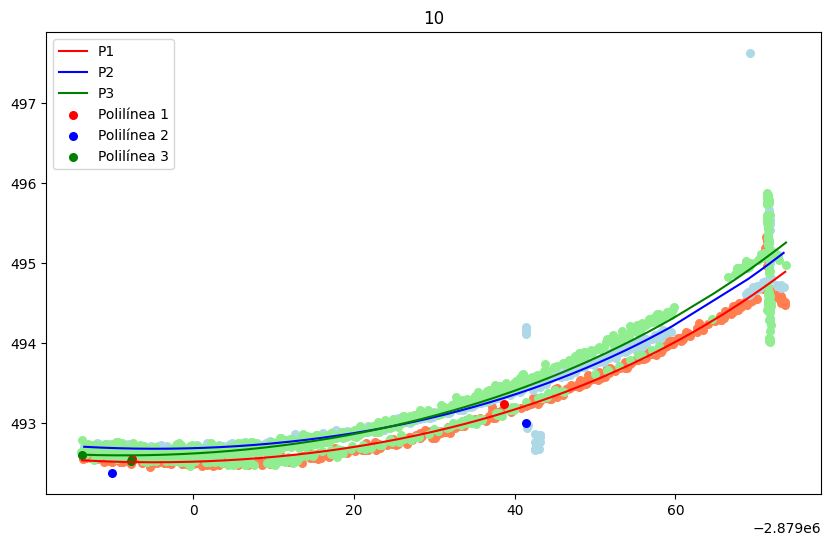

In [162]:
ajuste(data3, 10)